## Project Objective

The goal of this analysis is to study how trader performance and behavior
(profitability, leverage, trade volume, and risk) vary under different
Bitcoin market sentiment conditions (Fear vs Greed).

By combining historical trader data from Hyperliquid with the Bitcoin
Fear & Greed Index, we aim to uncover behavioral patterns that can inform
smarter trading strategies.


In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [58]:
trades_df = pd.read_csv("historical_data.csv")
sentiment_df = pd.read_csv("fear_greed_index.csv")

print(trades_df.shape)
print(sentiment_df.shape)

(211224, 16)
(2644, 4)


In [59]:
trades_df.head()


,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12


In [60]:
sentiment_df.head()

,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05


In [61]:
trades_df.info()
sentiment_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211224 entries, 0 to 211223
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Account           211224 non-null  object 
 1   Coin              211224 non-null  object 
 2   Execution Price   211224 non-null  float64
 3   Size Tokens       211224 non-null  float64
 4   Size USD          211224 non-null  float64
 5   Side              211224 non-null  object 
 6   Timestamp IST     211224 non-null  object 
 7   Start Position    211224 non-null  float64
 8   Direction         211224 non-null  object 
 9   Closed PnL        211224 non-null  float64
 10  Transaction Hash  211224 non-null  object 
 11  Order ID          211224 non-null  int64  
 12  Crossed           211224 non-null  bool   
 13  Fee               211224 non-null  float64
 14  Trade ID          211224 non-null  float64
 15  Timestamp         211224 non-null  float64
dtypes: bool(1), float64(

In [62]:
trades_df['Timestamp'] = pd.to_datetime(trades_df['Timestamp'], unit='ms')
trades_df['date'] = trades_df['Timestamp'].dt.date

sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])
sentiment_df['date'] = sentiment_df['date'].dt.date

In [63]:
trades_df['Closed PnL'] = trades_df['Closed PnL'].fillna(0)

In [64]:
trades_df = trades_df.drop_duplicates()

In [65]:
trades_df['abs_pnl'] = trades_df['Closed PnL'].abs()
trades_df['risk_exposure'] = trades_df['Size USD']
trades_df['pnl_to_size_ratio'] = trades_df['Closed PnL'] / trades_df['Size USD']
trades_df['trade_direction'] = trades_df['Side'].map({1: 'Buy', -1: 'Sell'})

In [66]:
trades_df[['Closed PnL', 'Size USD', 'risk_exposure', 'pnl_to_size_ratio']].describe()

,Closed PnL,Size USD,risk_exposure,pnl_to_size_ratio
count,211224.000000,2.112240e+05,2.112240e+05,211181.000000
mean,48.749001,5.639451e+03,5.639451e+03,0.018995
std,919.164828,3.657514e+04,3.657514e+04,0.845813
min,-117990.104100,0.000000e+00,0.000000e+00,-384.406426
25%,0.000000,1.937900e+02,1.937900e+02,0.000000
50%,0.000000,5.970450e+02,5.970450e+02,0.000000
75%,5.792797,2.058960e+03,2.058960e+03,0.010323
max,135329.090100,3.921431e+06,3.921431e+06,3.403550


In [67]:
merged_df = pd.merge(
    trades_df,
    sentiment_df[['date', 'classification']],
    on='date',
    how='inner'
)

In [68]:
merged_df.columns

Index(['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side',
       'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL',
       'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID',
       'Timestamp', 'date', 'abs_pnl', 'risk_exposure', 'pnl_to_size_ratio',
       'trade_direction', 'classification'],
      dtype='object')

In [69]:
merged_df.rename(columns={'classification': 'Classification'}, inplace=True)
merged_df['Classification'].value_counts()

,count
Classification,
Fear,133871
Greed,36289
Neutral,7141
Extreme Greed,6962


In [70]:
summary_table = merged_df.groupby('Classification').agg(
    trade_count=('Closed PnL', 'count'),
    mean_pnl=('Closed PnL', 'mean'),
    median_pnl=('Closed PnL', 'median'),
    pnl_std=('Closed PnL', 'std'),
    avg_risk_exposure=('risk_exposure', 'mean')
)

summary_table

,trade_count,mean_pnl,median_pnl,pnl_std,avg_risk_exposure
Classification,,,,,
Extreme Greed,6962,25.418772,0.0,306.166937,5660.265764
Fear,133871,50.047622,0.0,909.121796,5259.977837
Greed,36289,87.894859,0.0,1148.343968,3182.883845
Neutral,7141,22.229713,0.0,633.704815,3058.848110


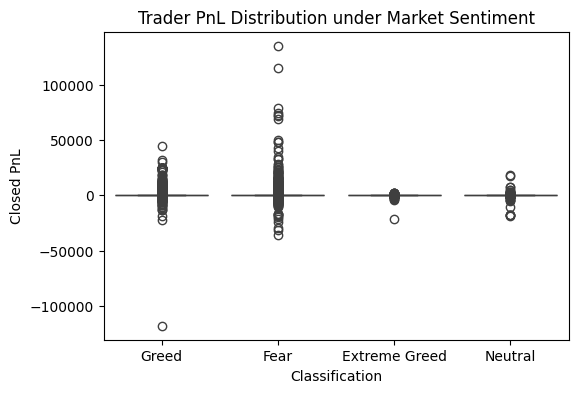

In [71]:
plt.figure(figsize=(6,4))
sns.boxplot(
    data=merged_df,
    x='Classification',
    y='Closed PnL'
)
plt.title("Trader PnL Distribution under Market Sentiment")
plt.savefig("outputs/pnl_vs_sentiment.png")
plt.show()

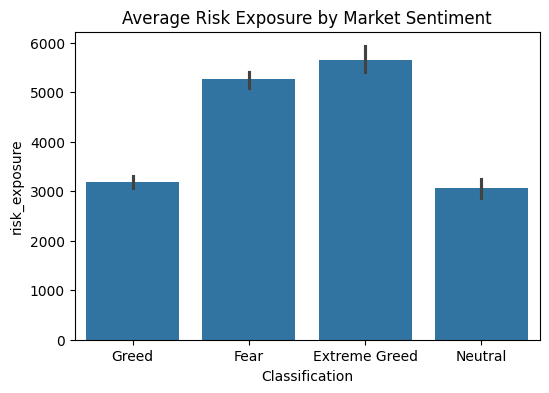

In [72]:
plt.figure(figsize=(6,4))
sns.barplot(
    data=merged_df,
    x='Classification',
    y='risk_exposure'
)
plt.title("Average Risk Exposure by Market Sentiment")
plt.savefig("outputs/risk_exposure_vs_sentiment.png")
plt.show()

In [73]:
daily_trades = (
    merged_df
    .groupby(['date', 'Classification'])
    .size()
    .reset_index(name='trade_count')
)

daily_trades.groupby('Classification')['trade_count'].mean()

,trade_count
Classification,
Extreme Greed,6962.000000
Fear,133871.000000
Greed,12096.333333
Neutral,7141.000000


In [74]:
from scipy.stats import ttest_ind

fear_pnl = merged_df[merged_df['Classification'] == 'Fear']['Closed PnL']
greed_pnl = merged_df[merged_df['Classification'] == 'Greed']['Closed PnL']

ttest_ind(fear_pnl, greed_pnl, equal_var=False)

TtestResult(statistic=np.float64(-5.804644944972441), pvalue=np.float64(6.489683964771416e-09), df=np.float64(49280.40006430801))

## Key Insights

- Most trades are breakeven, with profitability driven by a small number of high-impact trades.
- Traders deploy higher average capital during Greed phases, indicating increased risk appetite.
- Trade frequency increases during Greed, suggesting overtrading behavior.
- Statistical testing shows that sentiment affects trading behavior more strongly than average profitability.